<h1>Calibracion ADC</h1>

<h3>Objetivo</h3>

Caracterizar el ADC de un Arduino Mega y corregir los errores de offset y ganancia del mismo


<h3>Desarrollo</h3>


A continuacion se mostraran los pasos que se llevaron a cabo para realizar la calibracion y cuales fueron los resultados obtenidos.


1) Se realiza la muestra de todas las cuentas del ADC mediante instrumentacion virtual. Con este paso se obtiene un CSV, en donde habra una cantidad N de mediciones por cada paso del ADC.

En este caso se realizaron 5 muestras de cada tension inyectada con el Generador de funciones. Luego el paso entre cada tension generada es de 4 mediciones por LSB, por lo que se repitieron 5 mediciones cada LSB/4 hasta llegar a la tension de alimentacion (5V). Dando un total de 20.480 mediciones.

2) Una vez obtenidas las muestras se procede procesar los datos, para lo cual ingresamos las mediciones en python y luego promediamos para cada cuenta la media de los valores de tension obtenidos.

3) Ya teniendo los datos disponibles y promedidados, se calcula el DNL, para lo cual se deben tener los valores de Delta V ideales y asi poder compararlos con los valores obtenidos.

4) Con los valores de DNL se determinan los missing codes del ADC

5) Se grafica la curva INL a partir de los valores medidos.

6) Se determina la curva Best Fit para el paso anterior y se corrige tanto el Offset como la ganancia.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

archivo_csv = "/content/drive/MyDrive/4. ME1/Grupo 1/TP 4/Mediciones/mediciones_medio_LSB.csv"

# Cargar el archivo CSV en un DataFrame de Pandas
df = pd.read_csv(archivo_csv, delimiter=';')  # Cambia el delimitador si es necesario


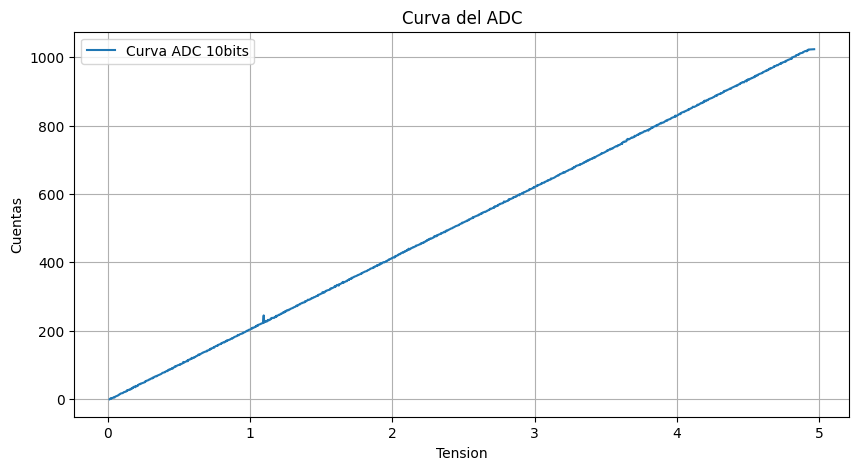

In [ ]:
#Ajusto los valores del CSV (hubo un error al momento de tomar las mediciones y quedaron los datos *2)
df['vGen'] = df['vGen'] / 2

# Agrupo y obtengo la media de todos los valores que hayan dado el mismo valor de Cuenta y luego los ordeno en un vector
means_df = df.groupby("Cuenta")["vGen"].mean()
means_df = means_df.sort_values(ascending=True)

# Obtengo los valores de las cuentas y los valores de tension para graficar
valores_medidos = means_df.values.tolist()
cuentas_adc  = means_df.index.tolist()

#ploteo los valores obtenidos

plt.figure(figsize=(10, 5))
plt.plot(valores_medidos, cuentas_adc, label='Curva ADC 10bits')

plt.xlabel('Tension')
plt.ylabel('Cuentas')
plt.title('Curva del ADC')
plt.legend()
plt.grid(True)  # Agregar una cuadrícula

plt.show()

<h3>Error DNL </h3>

El error DNL es la caracterizacion de la diferencia entre la transferencia ideal y la transferencia real. Es una medida de cuánto varía el tamaño de los pasos entre las transiciones de nivel de cuantización del ADC. En otras palabras, mide la no uniformidad en los incrementos entre niveles adyacentes de cuantización. Una respuesta de DNL en cero para todas las muestras implica que tanto la curva ideal de transferencia como la curva real coinciden.

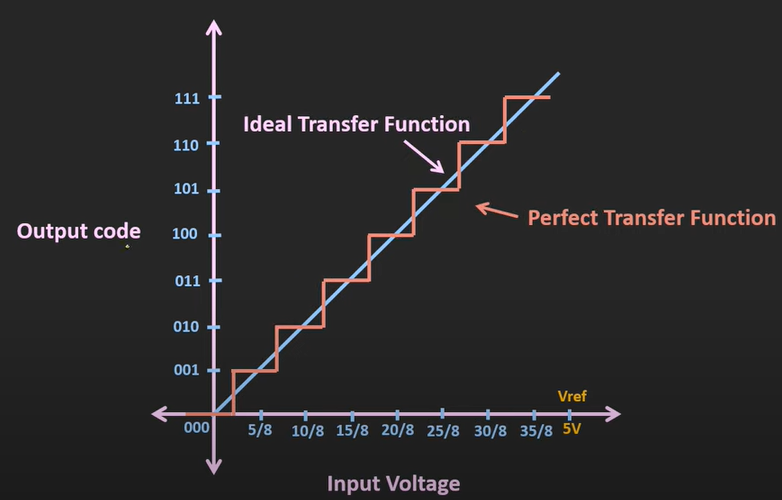

Sin embargo esto no ocurre en la realidad y lo que realmente se obtiene es un respuesta como la siguiente:

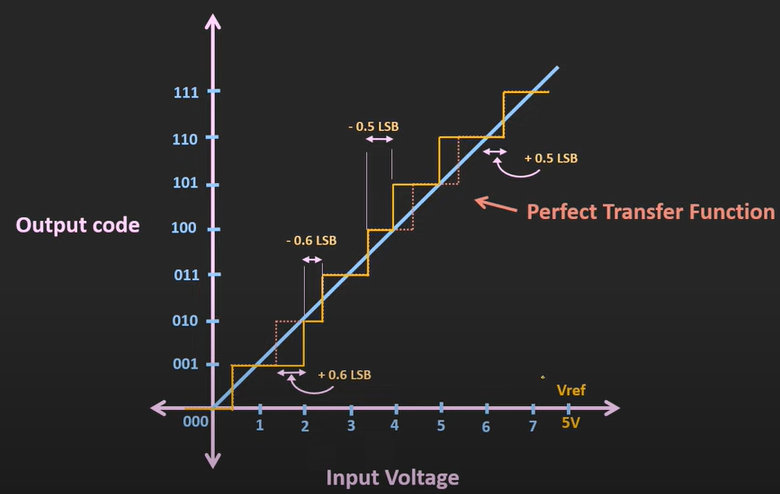

Donde existe una diferencia entre el valor ideal y el valor real representada en LSB. Este valor es lo que representa el DNL.

Mientras el DNL sea menor en modulo a 1 significa que todos los codigos tienen un valor de representacion. Sin embargo en ocasiones ocurre que algunos valores de DNL son mayores a uno, lo que implica que existe un codigo que no es posible representarlo y entonces perdemos la posibilidad de medirlo. A estos casos se los denomina "missing codes".

A continuacion se determina el grafico de DNL.

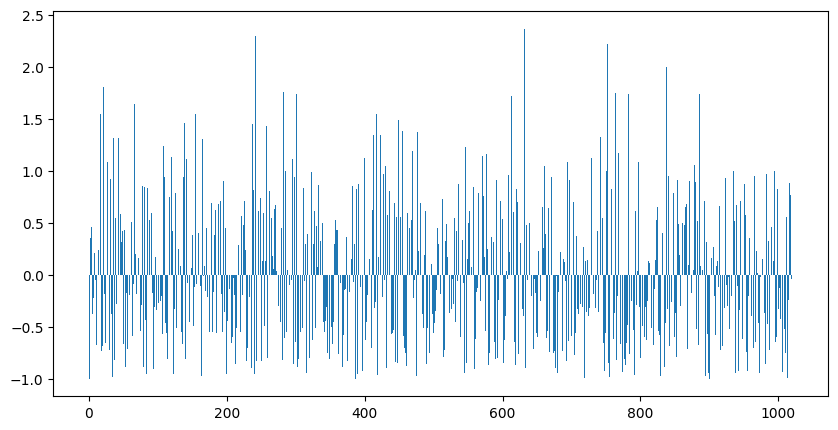

Maximo DNL: 2.3670286723536265


In [ ]:
### Creo grafica de DNL (grafico de barras)

tension = 5 #Tension del ADC
nrCuentas = 1024 # Numero de cuentas totales (10 bits)

#Obtengo delta ideal de tension

deltaV_ideal = tension / nrCuentas

#Obtengo deltas medidos de tension

valores_medidos_deltas = np.diff(valores_medidos)

# Calculo del DNL
vector_dnl = ((valores_medidos_deltas / deltaV_ideal) - 1 )[:-1] # El ultimo dato tiene basura

# ploteo el grafico del DNL
plt.figure(figsize=(10, 5))

plt.bar(cuentas_adc[:-2],vector_dnl)

plt.show()
print(f"Maximo DNL: {np.max(vector_dnl)}")

In [ ]:
# Imprimo las cuentas donde hay missing Codes
cuentas_adc = np.array(cuentas_adc)
missing_codes = cuentas_adc[:-2][vector_dnl > 1]
print("En las siguientes cuentas hay missing code:")
print(missing_codes)


En las siguientes cuentas hay missing code:
[   3.   17.   21.   27.   36.   43.   57.   60.   66.  108.  115.  120.
  129.  139.  142.  155.  165.  173.  203.  209.  237.  242.  258.  282.
  290.  295.  301.  319.  341.  348.  350.  373.  399.  400.  413.  417.
  423.  430.  449.  455.  469.  477.  499.  546.  556.  571.  577.  585.
  605.  613.  632.  644.  661.  683.  686.  692.  694.  718.  729.  731.
  742.  751.  752.  764.  768.  772.  776.  779.  783.  797.  808.  827.
  838.  878.  886.  901.  927.  935.  960.  972.  979.  985.  994. 1005.
 1011.]


Se puede observar que la cantidad de missing codes es muy grande, por lo que el ADC no es de buenas prestaciones.

<h3>Error INL </h3>

Evalúa la acumulación de errores de DNL en todo el rango de entrada del ADC. Es la suma de todas las no linealidades diferenciales a lo largo del rango de entrada del ADC. INL describe cuánto se desvía la salida del ADC de una respuesta lineal ideal.
Al igual que DNL, INL se expresa en unidades de LSB. Un ADC con un INL pequeño tiene una respuesta más lineal y se ajusta mejor a un modelo lineal ideal.

Para poder determinar esta curva, se obtiene la BestFit y con ella se calcula el valor del INL. Esto se hace de esta forma ya que el error de offset y de ganancia no deben ser considerados dentro de este error.

A continuacion se determina el grafico de INL

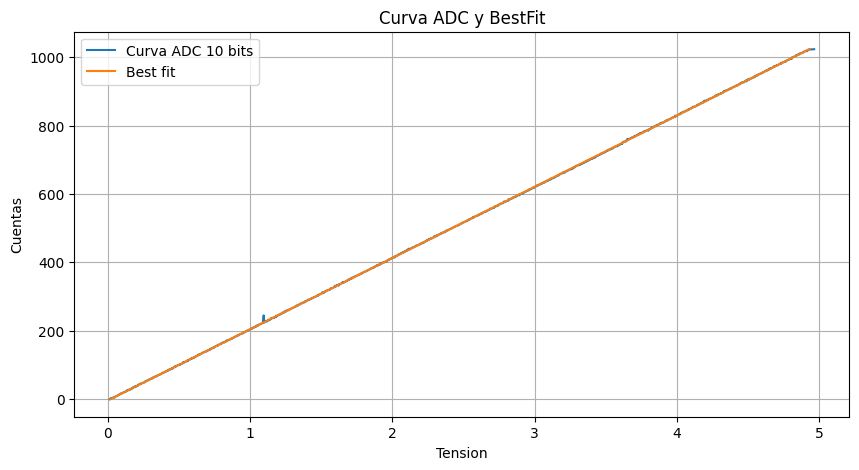

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(valores_medidos, cuentas_adc, label='Curva ADC 10 bits')

plt.xlabel('Tension')
plt.ylabel('Cuentas')
plt.title('Curva ADC y BestFit')

def recta(x, m, b):
    return m * x + b

# Obtengo la curva BestFit
params, _= curve_fit(recta,cuentas_adc, valores_medidos)
m, b = params

best_fit = m * cuentas_adc + b

# Ploteo la curva
plt.plot(best_fit, cuentas_adc, label='Best fit')
plt.legend()
plt.grid(True)  # Agregar una cuadrícula

plt.show()

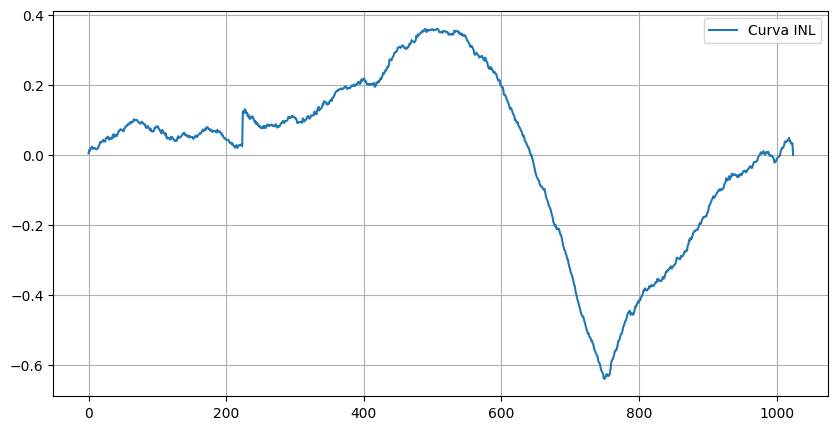

Maximo INL: 0.36015809455156245


In [ ]:
plt.figure(figsize=(10, 5))
cuentas = np.linspace(0, 1024,1024)

valores_inl = best_fit - valores_medidos

valores_inl = np.cumsum(valores_inl)

plt.plot( cuentas,valores_inl, label='Curva INL')
plt.legend()
plt.grid(True)  # Agregar una cuadrícula
plt.show()
print(f"Maximo INL: {np.max(valores_inl)}")

<h3>Correccion BestFit </h3>

A continuacion se corrige la curva Best Fit eliminando el OffSet y modificando la ganancia.



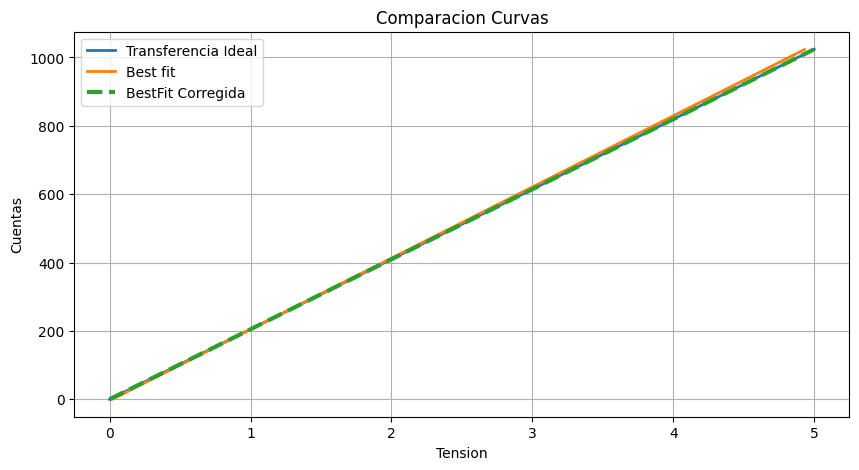

In [ ]:
plt.figure(figsize=(10, 5))

# Ploteo La transferencia ideal
cuentas = np.linspace(0, 1024,1024)
trans_ideal = cuentas * deltaV_ideal
plt.plot(trans_ideal, cuentas, label='Transferencia Ideal',linewidth = 2)

#Ploteo la BestFit
plt.plot(best_fit, cuentas_adc, label='Best fit',linewidth = 2)

# Ploteo la BestFit corregida
correccion_offset = - b
correccion_gain = deltaV_ideal / m
best_fit_correc = best_fit*correccion_gain + correccion_offset
plt.plot(best_fit_correc, cuentas_adc,linestyle = "--", label='BestFit Corregida',linewidth = 3)

# Configuro el grafico
plt.title("Comparacion Curvas")
plt.xlabel('Tension')
plt.ylabel('Cuentas')
plt.legend()
plt.grid(True)

plt.show()


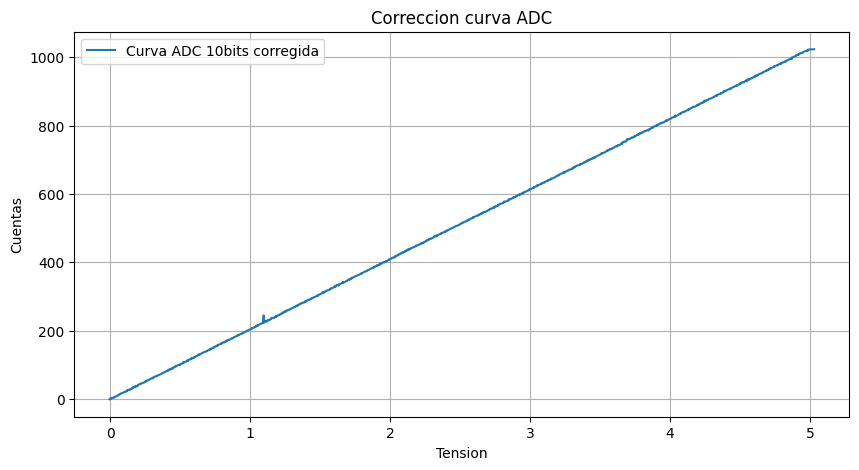

In [ ]:

## Muestro finalmente la curva real corregida
plt.figure(figsize=(10, 5))

## Corrijo los valores medidos
valores_medidos =np.array(valores_medidos) * correccion_gain + correccion_offset
plt.plot(valores_medidos, cuentas_adc, label='Curva ADC 10bits corregida')

#Configuro el grafico
plt.title("Correccion curva ADC")
plt.xlabel('Tension')
plt.ylabel('Cuentas')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print(f"Los valores para realizar la calibracion son:\nValor Calibrado = [Medicion ADC] x {round(correccion_gain,3)} - {-round(correccion_offset,3)} \n")

Los valores para realizar la calibracion son:
Valor Calibrado = [Medicion ADC] x 1.017 - 0.019 

